# Customer Segmentation Report

In [1]:
%matplotlib inline
import pickle

# data processing
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Cluster Explainability
import shap

# Import Data
the dataset is available here: https://archive.ics.uci.edu/ml/datasets/adult

In [2]:
# load the local dataset 
df = pd.read_csv('../data/adult_dataset.csv')

# Relabel taget colum since there is no target in unsupervised learning
df.rename(columns={"Target": "Income"}, inplace=True)

# Correct the Income column typo
df['Income'] = df['Income'].apply(lambda x: x.replace('.', ''))

df.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Load Model Artifacts

In [3]:
with open('../artifacts/numeric_imputer.pickle', 'rb') as filename: # trained model to impute missing numeric data
    numeric_imputer = pickle.load(filename)

with open('../artifacts/categorical_imputer.pickle', 'rb') as filename: # trained model to impute missing categorical data
    categorical_imputer = pickle.load(filename) 

with open('../artifacts/rare_encoder.pickle', 'rb') as filename: # trained model to encode rare labels
    rare_encoder = pickle.load(filename)

with open('../artifacts/capper.pickle', 'rb') as filename: # trained model to cap outliers
    capper = pickle.load(filename)   

with open('../artifacts/enc.pickle', 'rb') as filename: # trained one hot encoder
    enc = pickle.load(filename)

with open('../artifacts/model.pickle', 'rb') as filename: # trained random forrest classifier
    model = pickle.load(filename)

# Transform Dataset

In [4]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df.select_dtypes(include=numerics).columns.to_list()
categorical_columns = df.select_dtypes(exclude=numerics).columns.to_list()

In [5]:
# impute mising numeric features
df_numeric = pd.DataFrame(
    numeric_imputer.transform(df[numeric_columns]), 
    columns=numeric_columns, 
    index=df.index)

# impute mising categorical features
df_categorical = pd.DataFrame(
    categorical_imputer.transform(df[categorical_columns]), 
    columns=categorical_columns, 
    index=df.index)

# concate numeric and categorical features
df = pd.concat([df_numeric, df_categorical], axis=1)

# remove rare labels
df[categorical_columns] = rare_encoder.transform(df[categorical_columns])

# remove outliers
df[numeric_columns] = capper.transform(df[numeric_columns])

# one hot encoding categorical features
df_cat_hotenc = pd.DataFrame(
    enc.transform(df[categorical_columns]), 
    columns=enc.get_feature_names_out(),
    index=df.index) 

# concate numeric and hot-encoded categorical features
df_hotenc = pd.concat([df[numeric_columns], df_cat_hotenc], axis=1)

# predict cluster
labels = model.predict(df_hotenc)

# add cluster label to df
df['cluster'] = labels

df.head()

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income,cluster
0,39.0,77516.0,13.0,2174.0,0.0,40.0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K,0
1,50.0,83311.0,13.0,0.0,0.0,13.0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K,0
2,38.0,215646.0,9.0,0.0,0.0,40.0,Private,HS-grad,Divorced,Rare,Not-in-family,White,Male,United-States,<=50K,2
3,53.0,234721.0,7.0,0.0,0.0,40.0,Private,Rare,Married-civ-spouse,Rare,Husband,Black,Male,United-States,<=50K,0
4,28.0,338409.0,13.0,0.0,0.0,40.0,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Rare,<=50K,0


# Data Visualization

In [6]:
# Cluster Counts
df['cluster'].value_counts()

0    27198
1    12208
2     8246
3     1190
Name: cluster, dtype: int64

## What does the Cluster Distribution Lool Like?

In [7]:
# Cluster Counts
cluster_labels = []
for c in df['cluster'].value_counts().index.tolist():
    if c == 0:
        label = 'Noise Cluster'
    else:
        label = 'Cluster ' + str(c)
    cluster_labels.append(label)

cluster_labels

['Noise Cluster', 'Cluster 1', 'Cluster 2', 'Cluster 3']

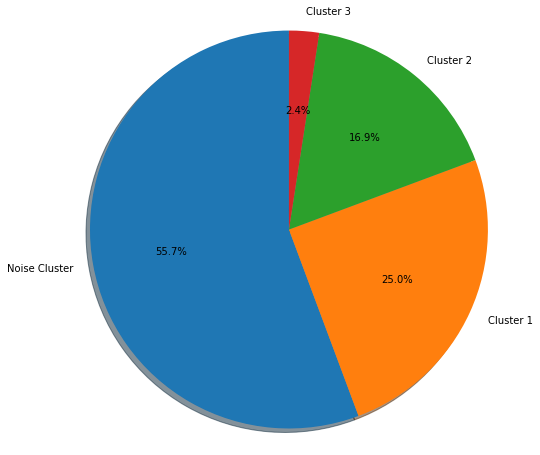

In [8]:
labels = cluster_labels
sizes = df['cluster'].value_counts().to_list()
explode = (0, 0, 0, 0)  

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(
    x=sizes, 
    explode=explode, 
    labels=labels, 
    autopct='%1.1f%%',
    shadow=True, 
    startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

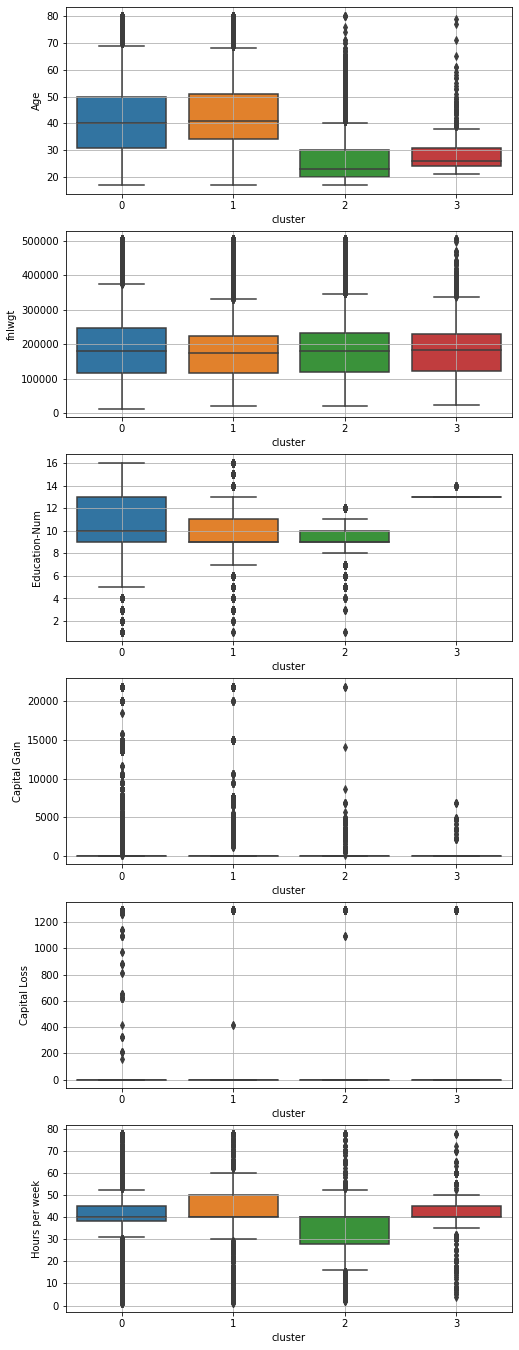

In [9]:
# boxplots for numeric columns

fig, ax = plt.subplots(
        figsize=(8,24), 
        nrows=len(numeric_columns), ncols=1, 
        sharex=False)

for n in range(len(numeric_columns)):
    sns.boxplot(
        data=df,
        x='cluster',
        y=numeric_columns[n],
        whis=1.0,
        ax=ax[n]
    )
    ax[n].grid()
#plt.show()

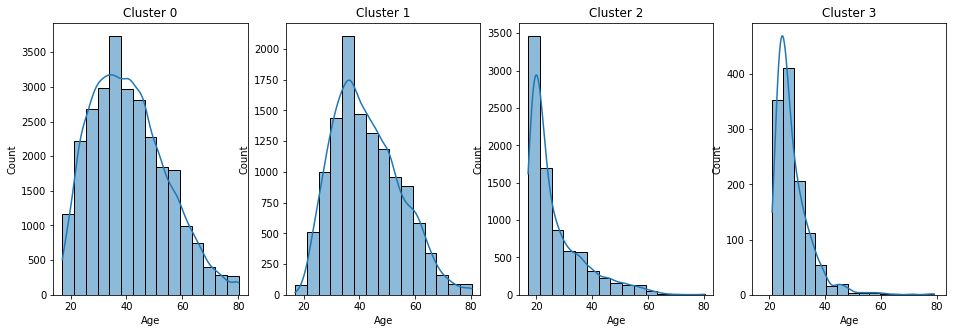

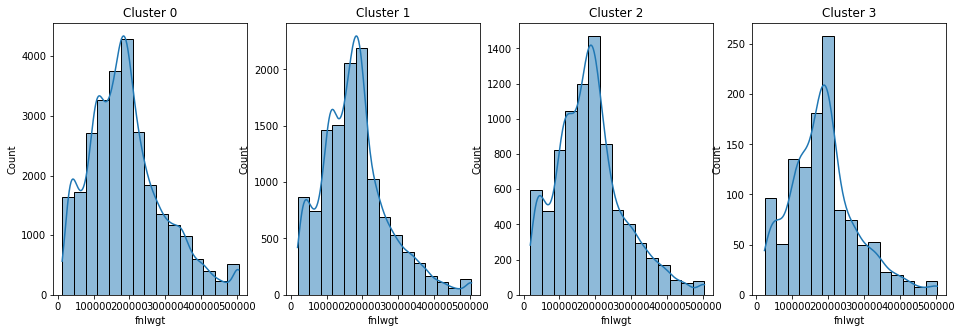

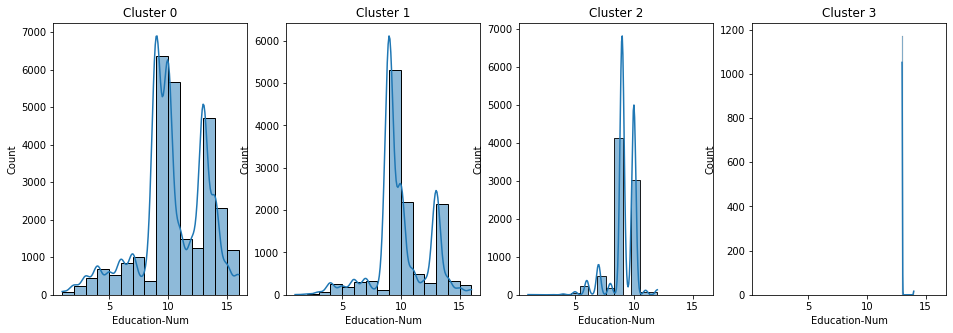

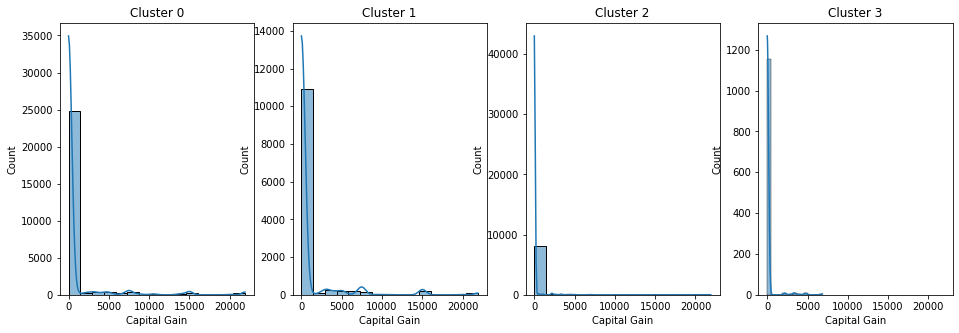

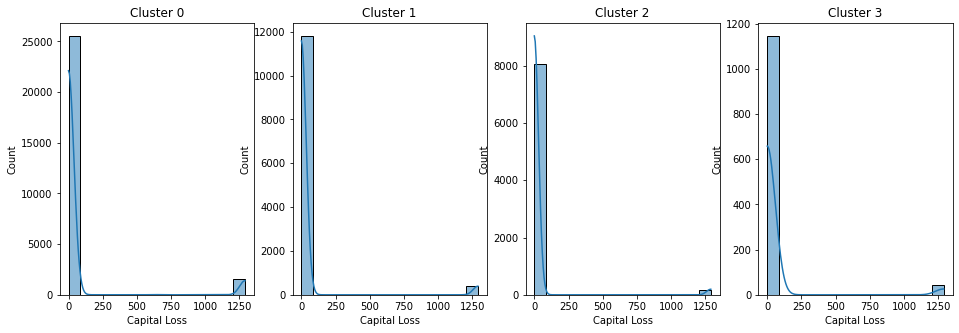

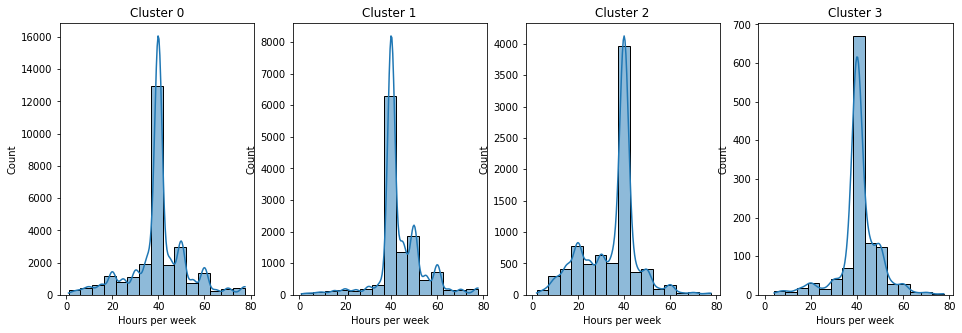

In [10]:
# visualize numeric features for each cluster
for feat in numeric_columns:

    fig, ax = plt.subplots(
        figsize=(16,5), 
        nrows=1, ncols=df['cluster'].nunique(), 
        sharex=True)
    
    for c in np.sort(df['cluster'].unique()):

        sns.histplot(
            data=df[df['cluster']==c], 
            x=feat,
            bins=15,
            kde=True,
            ax=ax[c])
        ax[c].set_title('Cluster '+str(c))
    plt.show()

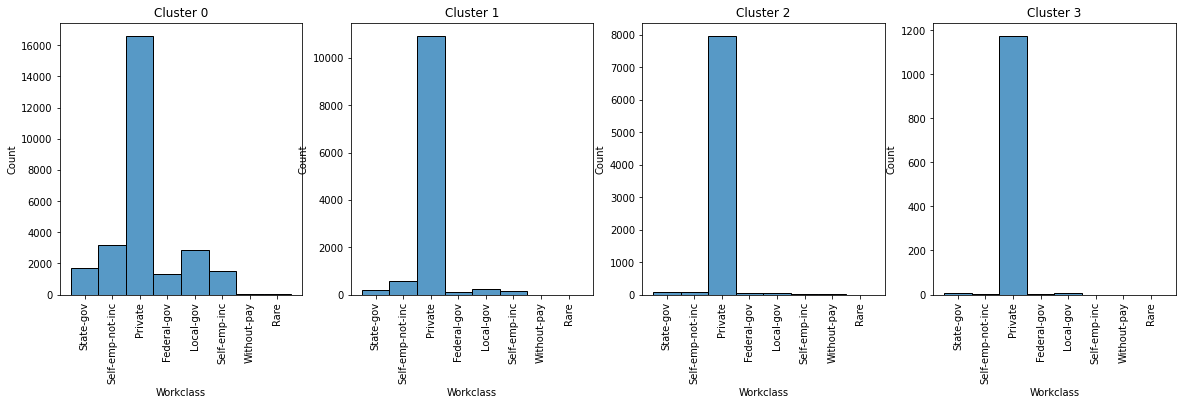

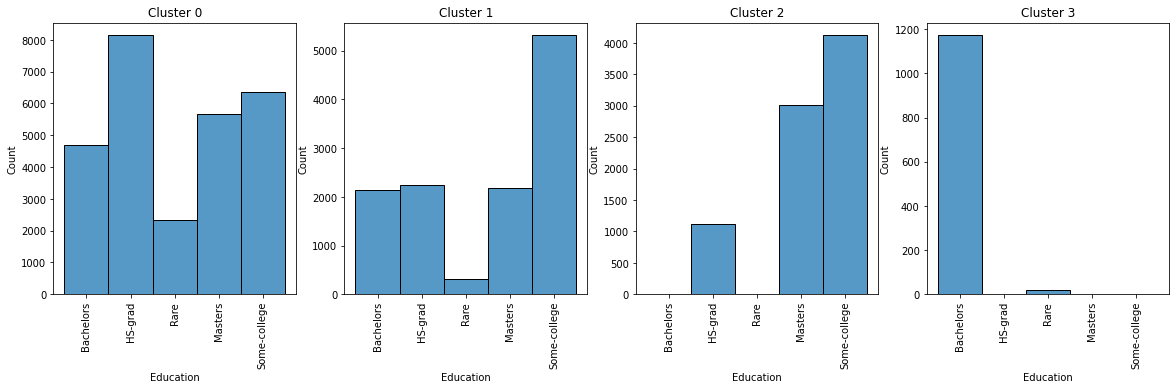

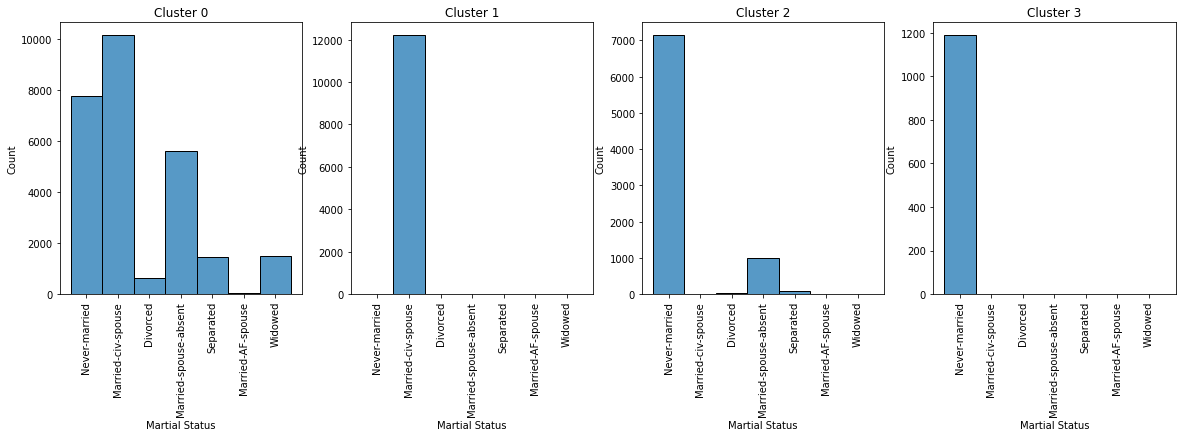

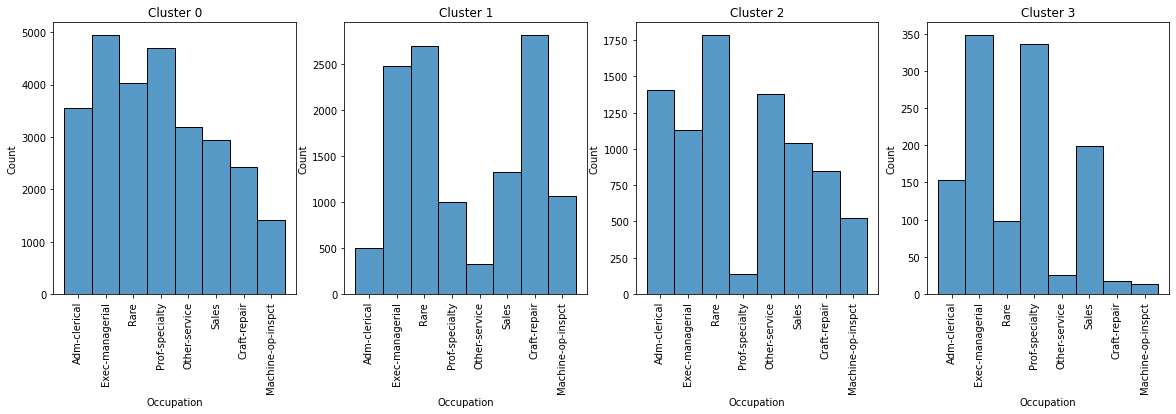

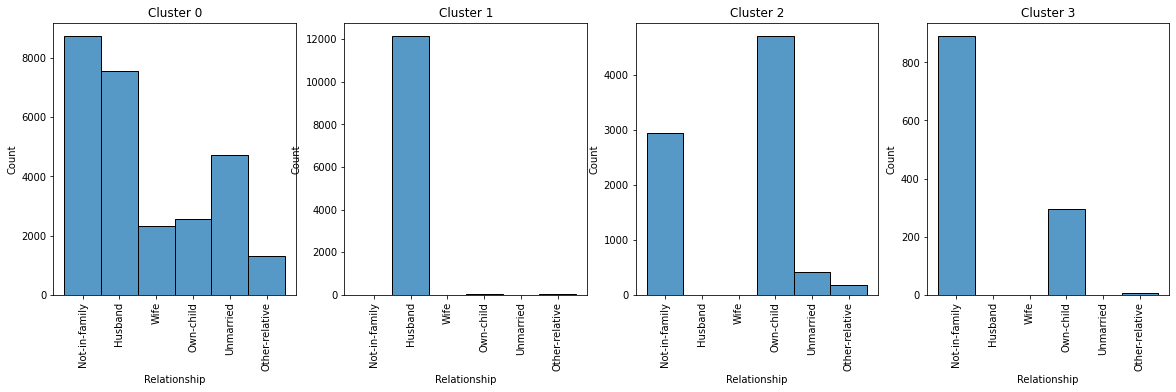

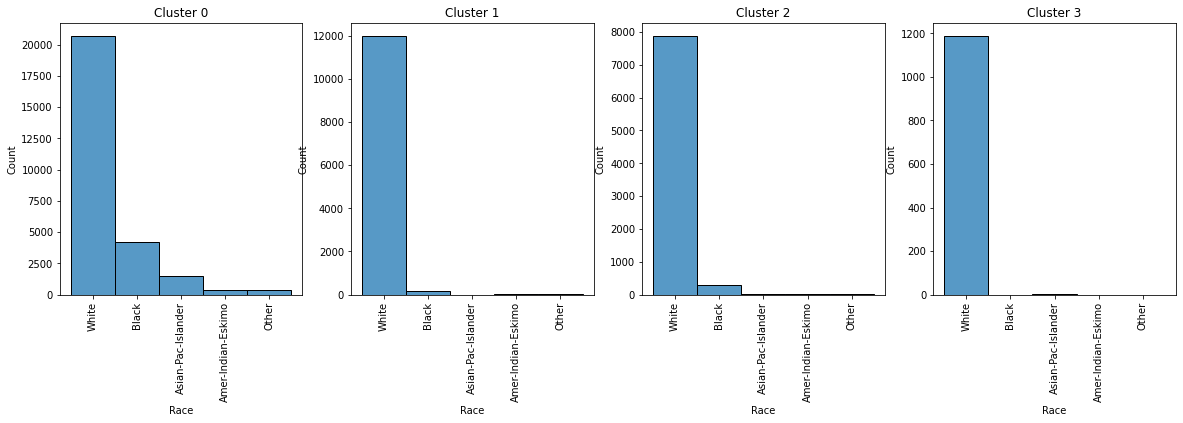

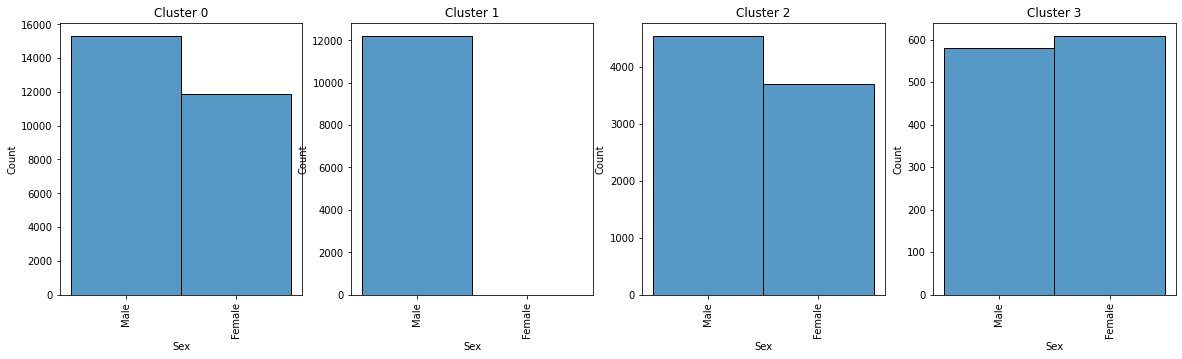

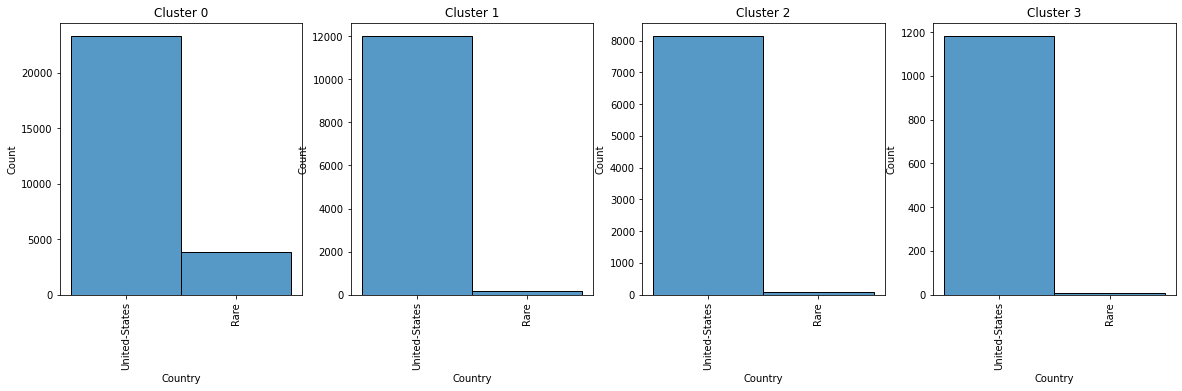

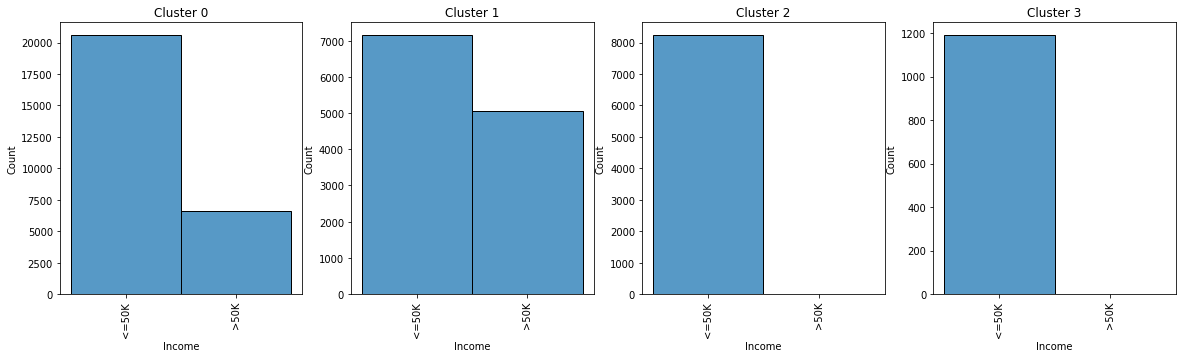

In [11]:
# visualize categorical features for each cluster
for feat in categorical_columns:

    fig, ax = plt.subplots(
        figsize=(20,5), 
        nrows=1, ncols=df['cluster'].nunique(), 
        sharex=True)
    
    for c in np.sort(df['cluster'].unique()):

        sns.histplot(
            data=df[df['cluster']==c], 
            x=feat,
            ax=ax[c])    
        ax[c].set_xticks(ax[c].get_xticks(), df[feat].unique(), rotation=90)
        ax[c].set_title('Cluster '+str(c))
        #ax[c].grid()
    plt.show()

# Determine Cluster Centers or What does the Average Customer in each Cluster Look Like?

In [12]:
pd.concat(
    [df.groupby(by='cluster', axis=0).median(),
    df.groupby(by='cluster', axis=0).agg(pd.Series.mode)[categorical_columns]], 
    axis=1) 

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
cluster,,,,,,,,,,,,,,,
0,40.0,180097.5,10.0,0.0,0.0,40.0,Private,Rare,Married-civ-spouse,Exec-managerial,Not-in-family,White,Male,United-States,<=50K
1,41.0,174201.0,9.0,0.0,0.0,40.0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K
2,23.0,180339.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Rare,Own-child,White,Male,United-States,<=50K
3,26.0,184002.0,13.0,0.0,0.0,40.0,Private,Bachelors,Never-married,Exec-managerial,Not-in-family,White,Female,United-States,<=50K


In [13]:
df[df['cluster']==0].describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,cluster
count,27198.000000,27198.000000,27198.000000,27198.000000,27198.000000,27198.000000,27198.0
mean,40.911580,192300.261221,10.287227,806.467609,77.508181,40.389680,0.0
std,13.330939,103834.974440,2.911941,3177.586100,305.507298,12.369701,0.0
min,17.000000,12285.000000,1.000000,0.000000,0.000000,1.000000,0.0
25%,31.000000,117202.750000,9.000000,0.000000,0.000000,38.000000,0.0
50%,40.000000,180097.500000,10.000000,0.000000,0.000000,40.000000,0.0
75%,50.000000,246457.250000,13.000000,0.000000,0.000000,45.000000,0.0
max,80.185586,504356.140360,16.000000,21900.984570,1290.295683,77.575579,0.0


# Explain Clusters

In [14]:
# Tree Explainer
explainer = shap.TreeExplainer(
    model = model.best_estimator_,
    output = 'probability')

In [15]:
X = df_hotenc.sample(1000)
shap_values = explainer.shap_values(X)

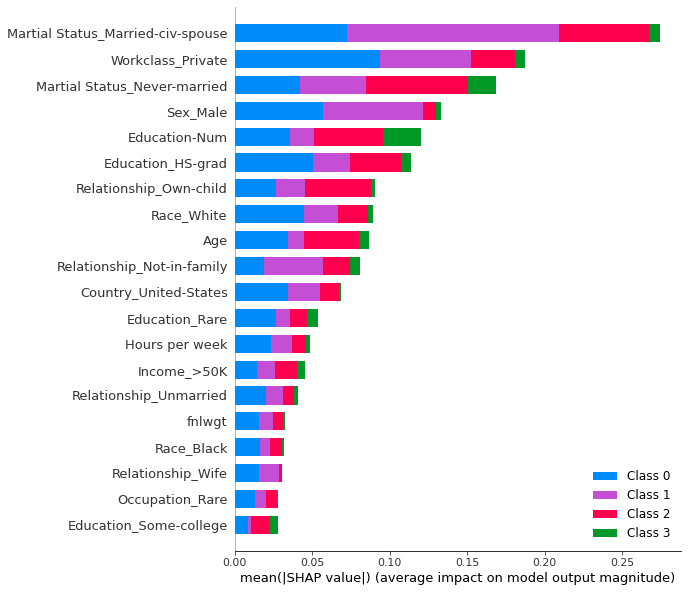

In [16]:
fig = shap.summary_plot(
    shap_values = shap_values, 
    features = X,
    sort=True,
    plot_size=(8.0,10.0)
    )
fig

# Explain Single Class vs Rest

In [17]:
cluster =  3

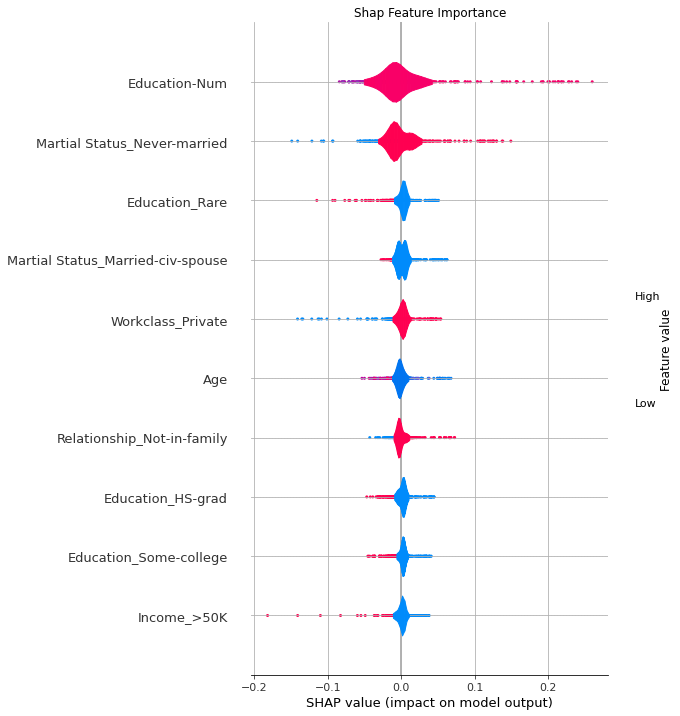

In [18]:
shap.summary_plot(
    shap_values = shap_values[cluster], 
    features = X,
    sort=True,
    plot_size=(8.0,12.0),
    show=False,
    max_display=10,
    plot_type='violin'
    )
ax=plt.gca()
ax.set_title('Shap Feature Importance')
ax.grid()
fig = plt.gcf()
plt.show()


# Explain Single Prediction

In [19]:
explainer.expected_value

array([0.55084028, 0.24625932, 0.17716689, 0.02573351])

In [20]:
# print the JS visualization code to the notebook
shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value[1], 
    shap_values = shap_values[1][0,:], 
    features = X.iloc[0,:],
    matplotlib = False,
    figsize=(18, 9)
    )